In [1]:
# !pip install scikit-multilearn==0.2.0

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.adapt import MLkNN
import sklearn.metrics as metrics
from sklearn.metrics import hamming_loss, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import multilabel_confusion_matrix
import os

In [4]:
d2= pd.read_csv('train_en_l1.csv')
d2
d2 = d2.rename(columns={'key' : 'unique_id', 'sentence' : 'text'})
d2.to_csv('updated_train_en_l1.csv', index=False)
# d2

# Convert annotator columns to numeric without replacing NaNs
d2[['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']] = d2[
    ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']
].apply(pd.to_numeric, errors='coerce')  # NaNs are retained

# Compute 'label' based on majority voting while ignoring NaNs
d2['label'] = (d2[['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']].mean(axis=1, skipna=True) >= 0.5).astype(int)
d2


,text,unique_id,en_a1,en_a2,en_a3,en_a4,en_a5,en_a6,label
0,"This is our history . For Shia and Sunni ,...",question_1,NaN,NaN,NaN,NaN,NaN,0.0,0
1,"If this is ""grilling"" then wht wud u call t...",question_1,NaN,NaN,NaN,1.0,NaN,NaN,1
2,look at <handle replaced>madam. Locals attac...,question_1,NaN,NaN,NaN,NaN,0.0,NaN,0
3,our beloved yogi ji has given money home and...,question_1,NaN,NaN,NaN,NaN,1.0,NaN,1
4,"""I gonna kill that bitch"" Bitvj imma kill you...",question_1,NaN,NaN,NaN,NaN,NaN,1.0,1
...,...,...,...,...,...,...,...,...,...
6526,“mama let’s research” bitch suck my dick 😭,question_1,NaN,NaN,NaN,NaN,0.0,NaN,0
6527,😂😂😂😂 I WAS BY MYSELF AND IT WAS HER AND HER BI...,question_1,NaN,NaN,NaN,NaN,0.0,NaN,0
6528,😂😂😂😂😂😂😂😂😂 i just seen a comment and bitch IM C...,question_1,NaN,NaN,NaN,NaN,0.0,NaN,0
6529,"😎""Boys Only Luxury!!!!!!!!!!!!!!!!!!!!!!!!!!!""...",question_1,0.0,1.0,1.0,0.0,NaN,NaN,1


In [8]:
# Create binary label ('hate' or 'not_hate')
def determine_binary_label(label):
    return 'hate' if label == 1 else 'not_hate'

d2['binary_label'] = d2['label'].apply(determine_binary_label)

# # Reorder columns
d2 = d2[['unique_id', 'text', 'binary_label', 'label']]

In [9]:
d2.to_csv('updated_train_en_l1.csv', index=False)

In [10]:
## Word Pre-Processing ##
import nltk
nltk.download('stopwords')
import string
import re
wpt = nltk.WordPunctTokenizer()
stop_words_init = nltk.corpus.stopwords.words('english')
stop_words = [i for i in stop_words_init if i not in ('not','and','for')]
print(stop_words)
## Function to normalize text for pre-processing ##
def normalize_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub('<.*?>+', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    return text
## Apply the written function ##
d2.loc[:, 'text'] = d2['text'].apply(lambda x: normalize_text(x))
processed_list = []
for j in d2['text']:
    process = j.replace('...','')
    processed_list.append(process)

df_processed = pd.DataFrame(processed_list)
df_processed.columns = ['text']
df_processed.head(n=5)


<>:13: SyntaxWarning: invalid escape sequence '\['
<>:14: SyntaxWarning: invalid escape sequence '\S'
<>:18: SyntaxWarning: invalid escape sequence '\w'
<>:13: SyntaxWarning: invalid escape sequence '\['
<>:14: SyntaxWarning: invalid escape sequence '\S'
<>:18: SyntaxWarning: invalid escape sequence '\w'
C:\Users\krmri\AppData\Local\Temp\ipykernel_24592\3013580188.py:13: SyntaxWarning: invalid escape sequence '\['
  text = re.sub('\[.*?\]', ' ', text)
C:\Users\krmri\AppData\Local\Temp\ipykernel_24592\3013580188.py:14: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('https?://\S+|www\.\S+', ' ', text)
C:\Users\krmri\AppData\Local\Temp\ipykernel_24592\3013580188.py:18: SyntaxWarning: invalid escape sequence '\w'
  text = re.sub('\w*\d\w*', ' ', text)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krmri\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she'd", "she'll",

,text
0,this is our history for shia and sunni ...
1,if this is grilling then wht wud u call t...
2,look at madam locals attacked no religion...
3,our beloved yogi ji has given money home and...
4,i gonna kill that bitch bitvj imma kill you...


In [11]:
X = list(df_processed['text'])
y = d2[['label']].values
y

array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, Activation, Dropout, Dense, Flatten,
    Bidirectional, GRU, concatenate, SpatialDropout1D,
    GlobalMaxPooling1D, GlobalAveragePooling1D, Conv1D,
    Embedding, Input, Concatenate
)
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import MeanSquaredError

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

######## Textual Features for Embedding ###################
max_len = 100
max_features = 4479

# Tokenization
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

# Padding
X = pad_sequences(X, padding='post', maxlen=max_len)

print(X)  # Check the processed sequences

[[  12    6   68 ...    0    0    0]
 [  34   12    6 ...    0    0    0]
 [ 158   64  239 ...    0    0    0]
 ...
 [  10   41  387 ...    0    0    0]
 [1590 1170   69 ...    0    0    0]
 [ 461  294   27 ...    0    0    0]]


In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y

C:\Users\krmri\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [14]:
from keras.utils import to_categorical
y = to_categorical(y, num_classes=2)
y

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [19]:
import numpy as np
import json

# Load GloVe embeddings from JSON
with open('glove_embeddings.json', encoding="utf8") as f:
    embeddings_list = json.load(f)

# Convert the list of vectors to a dictionary with word indices as keys
embeddings_dictionary = {str(i): vector for i, vector in enumerate(embeddings_list)}

# Define tokenizer 
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
word_index = tokenizer.word_index
num_words = min(max_features, vocab_size)  # Limit vocab to max_features

# Get embedding dimension (from first vector in list)
embed_size = len(embeddings_list[0]) if embeddings_list else 0

# Initialize embedding matrix
embedding_matrix = np.zeros((num_words, embed_size))

# Fill embedding matrix with corresponding word vectors
for word, index in word_index.items():
    if index >= max_features:
        continue
    embedding_vector = embeddings_dictionary.get(word) or embeddings_dictionary.get(str(index))
    if embedding_vector is not None:
        embedding_matrix[index] = np.asarray(embedding_vector, dtype=np.float32)

print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (4479, 50)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 100, 50)        │       223,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 100, 50)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 64)        │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 256)       │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,200 (1.76 MB)

 Trainable params: 237,250 (926.76 KB)

 Non-trainable params: 223,950 (874.80 KB)

Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - accuracy: 0.7598 - f1_score: 0.0575 - loss: 0.5640 - val_accuracy: 0.7943 - val_f1_score: 0.0000e+00 - val_loss: 0.5128
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.7703 - f1_score: 0.0000e+00 - loss: 0.5451 - val_accuracy: 0.7943 - val_f1_score: 0.0000e+00 - val_loss: 0.5051
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 0.7910 - f1_score: 0.0376 - loss: 0.5123 - val_accuracy: 0.8086 - val_f1_score: 0.1304 - val_loss: 0.4952
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 0.7821 - f1_score: 0.0659 - loss: 0.5253 - val_accuracy: 0.8086 - val_f1_score: 0.1304 - val_loss: 0.4960
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.7977 - f1_score: 0.0781 - loss: 0.5052 - val_accuracy: 0.8067 - val_f1_score: 0.1217 - val_loss: 0.4898
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step  

Evaluation Results:
Precision: 0.8723
Recall: 0.5254
F1 Score: 0.4982

Classification

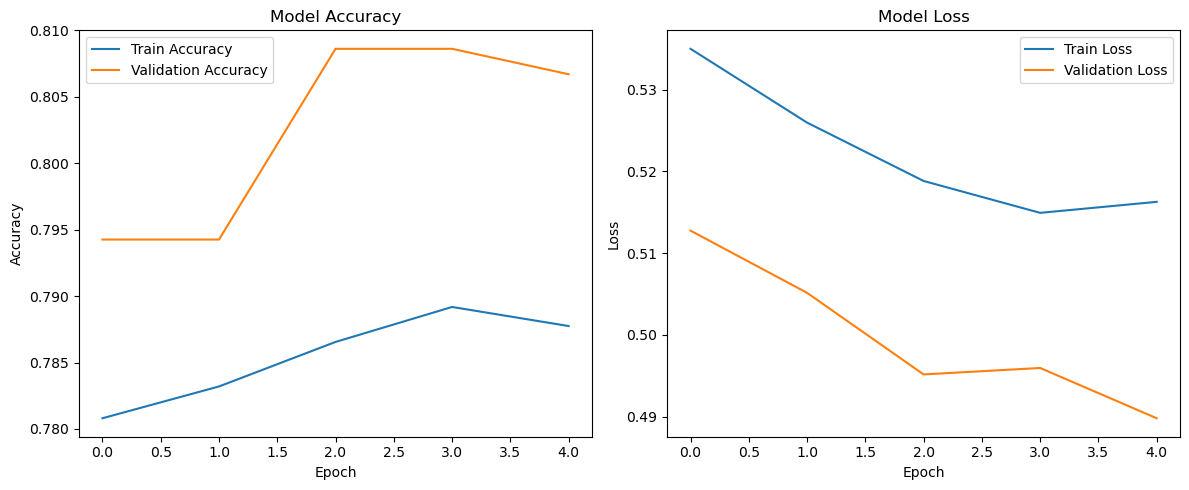

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, SpatialDropout1D, Conv1D,
    Bidirectional, LSTM, Dense, Dropout,
    GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Configure GPU for optimal performance
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

# Model Definition
def create_cnn_bilstm_model(max_len, max_features, embedding_matrix, embed_size=300):
    """
    Creates the CNN-BiLSTM model architecture as described in the paper
    """
    # Input layer
    input_layer = Input(shape=(max_len,))
    
    # Embedding layer with pretrained weights (GloVe/FastText)
    embedding_layer = Embedding(
        input_dim=max_features,
        output_dim=embed_size,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False  # As per paper, embeddings are non-trainable
    )(input_layer)
    
    # Spatial Dropout to prevent overfitting (as mentioned in paper)
    spatial_dropout = SpatialDropout1D(0.2)(embedding_layer)
    
    # CNN Layer (as described in paper)
    conv_layer = Conv1D(
        filters=64,  # As per paper
        kernel_size=2,  # As per paper
        activation='relu',
        padding='same'
    )(spatial_dropout)
    
    # Bidirectional LSTM Layer (as described in paper)
    bilstm_layer = Bidirectional(
        LSTM(
            units=128,  # As per paper
            return_sequences=True,
            dropout=0.1,  # As per paper
            recurrent_dropout=0.1  # As per paper
        )
    )(conv_layer)
    
    # Global Average Pooling (as per paper)
    gap_layer = GlobalAveragePooling1D()(bilstm_layer)
    
    # Dense layer (as per paper)
    dense_layer = Dense(128, activation='relu')(gap_layer)
    dropout_layer = Dropout(0.1)(dense_layer)  # Additional dropout as per paper
    
    # Output layer
    output_layer = Dense(2, activation='softmax')(dropout_layer)
    
    # Create model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

# Custom F1 Score Metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.argmax(y_true, axis=1)
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Model Training
def train_model(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=5):
    """
    Trains the CNN-BiLSTM model with early stopping and model checkpointing
    """
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_f1_score',
        patience=2,
        restore_best_weights=True,
        mode='max'
    )
    
    model_checkpoint = ModelCheckpoint(
        'best_model.weights.h5',  
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
        save_weights_only=True
    )
    
    # Compile model with Adam optimizer (as per paper)
    model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )
    
    return history, model

# Model Evaluation
def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model on test data and returns metrics as per the paper
    """
    # Predict probabilities
    y_pred_proba = model.predict(X_test, batch_size=32)
    
    # Convert to class labels
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Calculate metrics as per paper
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    # Classification report
    report = classification_report(y_true, y_pred, target_names=['not_hate', 'hate'])
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'classification_report': report
    }

# Main Execution
if __name__ == "__main__":
    # Assuming X, y are already prepared from your preprocessing
    # Split data into train and test (80/20 as per paper)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Further split train into train and validation (for early stopping)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    # Create model
    embed_size = embedding_matrix.shape[1]
    model = create_cnn_bilstm_model(max_len, max_features, embedding_matrix, embed_size)
    
    # Print model summary (as shown in paper's Figure 2)
    model.summary()
    
    # Train model (5 epochs as per paper)
    history, trained_model = train_model(
        model, X_train, y_train, X_val, y_val,
        batch_size=32,  # As per paper for Tasks 1 & 3
        epochs=5  # As per paper
    )
    
    # Evaluate model
    results = evaluate_model(trained_model, X_test, y_test)
    
    print("\nEvaluation Results:")
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    print(f"F1 Score: {results['f1_score']:.4f}")
    print("\nClassification Report:")
    print(results['classification_report'])
    
    # Plot training history (similar to paper's Figure 3)
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [39]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Embedding, SpatialDropout1D, Conv1D,
    Bidirectional, LSTM, Dense, Dropout,
    GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configure GPU for optimal performance
def configure_gpu():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Enable memory growth for each GPU
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
            # Use mixed precision for better performance
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
            print('Mixed precision enabled')
        except RuntimeError as e:
            print(e)

configure_gpu()

# Model Definition
def create_cnn_bilstm_model(max_len, max_features, embedding_matrix, embed_size=300):
    """
    Creates the CNN-BiLSTM model architecture as described in the paper
    """
    # Input layer
    input_layer = Input(shape=(max_len,))
    
    # Embedding layer with pretrained weights (GloVe/FastText)
    embedding_layer = Embedding(
        input_dim=max_features,
        output_dim=embed_size,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False  # As per paper, embeddings are non-trainable
    )(input_layer)
    
    # Spatial Dropout to prevent overfitting (as mentioned in paper)
    spatial_dropout = SpatialDropout1D(0.2)(embedding_layer)
    
    # CNN Layer (as described in paper)
    conv_layer = Conv1D(
        filters=64,  # As per paper
        kernel_size=2,  # As per paper
        activation='relu',
        padding='same'
    )(spatial_dropout)
    
    # Bidirectional LSTM Layer (as described in paper)
    bilstm_layer = Bidirectional(
        LSTM(
            units=128,  # As per paper
            return_sequences=True,
            dropout=0.1,  # As per paper
            recurrent_dropout=0.1  # As per paper
        )
    )(conv_layer)
    
    # Global Average Pooling (as per paper)
    gap_layer = GlobalAveragePooling1D()(bilstm_layer)
    
    # Dense layer (as per paper)
    dense_layer = Dense(128, activation='relu')(gap_layer)
    dropout_layer = Dropout(0.1)(dense_layer)  # Additional dropout as per paper
    
    # Output layer (use float32 for softmax for numerical stability)
    output_layer = Dense(2, activation='softmax', dtype='float32')(dropout_layer)
    
    # Create model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

# Custom F1 Score Metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.argmax(y_true, axis=1)
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Model Training
def train_and_validate_model(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=5, model_dir='models'):
    """
    Trains the CNN-BiLSTM model with early stopping and model checkpointing
    Returns the best model and training history
    """
    # Create directory for saving models if it doesn't exist
    os.makedirs(model_dir, exist_ok=True)
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_f1_score',
        patience=2,
        restore_best_weights=True,
        mode='max',
        verbose=1
    )
    
    model_checkpoint = ModelCheckpoint(
        os.path.join(model_dir, 'best_model.h5'),  # Save entire model
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
        verbose=1
    )
    
    # Compile model with Adam optimizer (as per paper)
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # Added explicit learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )
    
    # Load the best model found during training
    best_model = load_model(os.path.join(model_dir, 'best_model.h5'), 
                          custom_objects={'F1Score': F1Score})
    
    return history, best_model

# Plot Training History
def plot_training_history(history, plot_dir='plots_nlp_project'):
    """
    Plots training history (accuracy and loss curves)
    Saves plots to specified directory
    """
    os.makedirs(plot_dir, exist_ok=True)
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'training_history.png'))
    plt.close()

# Validation Evaluation
def evaluate_validation(model, X_val, y_val, plot_dir='plots'):
    """
    Evaluates the model on validation data and saves metrics and plots
    """
    os.makedirs(plot_dir, exist_ok=True)
    
    # Predict probabilities
    y_pred_proba = model.predict(X_val, batch_size=32)
    
    # Convert to class labels
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_val, axis=1)
    
    # Calculate metrics
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Classification report
    report = classification_report(y_true, y_pred, target_names=['not_hate', 'hate'])
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Hate', 'Hate'],
                yticklabels=['Not Hate', 'Hate'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Validation)')
    plt.savefig(os.path.join(plot_dir, 'confusion_matrix_val.png'))
    plt.close()
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'classification_report': report,
        'confusion_matrix': conf_matrix
    }

# Main Execution for Training and Validation
if __name__ == "__main__":
    # Split into train (80%) and validation (20%)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    
    # Create model
    embed_size = embedding_matrix.shape[1]
    model = create_cnn_bilstm_model(max_len, max_features, embedding_matrix, embed_size)
    
    # Print model summary
    model.summary()
    
    # Train model (5 epochs as per paper)
    history, trained_model = train_and_validate_model(
        model, X_train, y_train, X_val, y_val,
        batch_size=32,  # As per paper for Tasks 1 & 3
        epochs=5  # As per paper
    )
    
    # Plot training history
    plot_training_history(history)
    
    # Evaluate on validation set
    val_results = evaluate_validation(trained_model, X_val, y_val)
    
    print("\nValidation Results:")
    print(f"Precision: {val_results['precision']:.4f}")
    print(f"Recall: {val_results['recall']:.4f}")
    print(f"F1 Score: {val_results['f1_score']:.4f}")
    print("\nClassification Report:")
    print(val_results['classification_report'])

Training samples: 5224
Validation samples: 1307


C:\Users\krmri\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_8 (Embedding)         │ (None, 100, 50)        │       223,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_7             │ (None, 100, 50)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 100, 64)        │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 100, 256)       │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,200 (1.76 MB)

 Trainable params: 237,250 (926.76 KB)

 Non-trainable params: 223,950 (874.80 KB)

Epoch 1/5
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7805 - f1_score: 0.0160 - loss: 0.5560 
Epoch 1: val_f1_score improved from -inf to 0.00000, saving model to models\best_model.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 28s 128ms/step - accuracy: 0.7806 - f1_score: 0.0159 - loss: 0.5558 - val_accuracy: 0.8080 - val_f1_score: 0.0000e+00 - val_loss: 0.4921
Epoch 2/5
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7922 - f1_score: 0.0000e+00 - loss: 0.5143 
Epoch 2: val_f1_score did not improve from 0.00000
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.7922 - f1_score: 0.0000e+00 - loss: 0.5144 - val_accuracy: 0.8080 - val_f1_score: 0.0000e+00 - val_loss: 0.4819
Epoch 3/5
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7893 - f1_score: 0.0413 - loss: 0.5221     
Epoch 3: val_f1_score improved from 0.00000 to 0.06923, saving model to models\best_model.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.7893 - f1_score: 0.0414 - loss: 0.5220 - val_accuracy: 0.8148 - val_f1_score: 0.0692 - val_loss: 0.4779
Epoch 4/5
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8019 - f1_score: 0.1188 - loss: 0.4963 
Epoch 4: val_f1_score improved from 0.06923 to 0.10566, saving model to models\best_model.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.8019 - f1_score: 0.1187 - loss: 0.4963 - val_accuracy: 0.8187 - val_f1_score: 0.1057 - val_loss: 0.4837
Epoch 5/5
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8038 - f1_score: 0.1008 - loss: 0.4952 
Epoch 5: val_f1_score did not improve from 0.10566
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.8038 - f1_score: 0.1009 - loss: 0.4952 - val_accuracy: 0.8187 - val_f1_score: 0.1057 - val_loss: 0.4740
Restoring model weights from the end of the best epoch: 4.


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step  

Validation Results:
Precision: 0.8519
Recall: 0.8187
F1 Score: 0.7467

Classification Report:
              precision    recall  f1-score   support

    not_hate       0.82      1.00      0.90      1056
        hate       1.00      0.06      0.11       251

    accuracy                           0.82      1307
   macro avg       0.91      0.53      0.50      1307
weighted avg       0.85      0.82      0.75      1307

